# Machine learning model for Wave Energy Converters

This notebook contains the preparation of machine learning model for data set, which consists of positions and absorbed power outputs of wave energy converters (WECs) in four real wave scenarios from the souther coast of Australia. 
The dat set is publicliy available here:
<br/>
Neshat, M., Wagner, M., & Alexander, B. (2018). Wave Energy Converters [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5831S.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error, mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm.engine import train
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
import catboost as cb
import optuna
import warnings
import os
from scipy import stats

warnings.simplefilter(action='ignore', category=FutureWarning)

# Exploratory data analysis
We begin with preparing correct labels for our data set.
<br/>

In [2]:
labelsX = [f"X{i}" for i in range(1, 17)]
labelsY = [f"Y{i}" for i in range(1, 17)]
labelsP = [f"P{i}" for i in range(1, 17)]
labelsZ = "Powerall"
labels = labelsX + labelsY + labelsP
labels.append(labelsZ)
print(labels)

# adelaide_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Adelaide_Data.csv')
# perth_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Perth_Data.csv')
# sydney_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Sydney_Data.csv')
# tasmania_df = pd.read_csv('/content/drive/MyDrive/colab/energy_data/Tasmania_Data.csv')

adelaide_df = pd.read_csv('Adelaide_Data.csv')
perth_df = pd.read_csv('Perth_Data.csv')
sydney_df = pd.read_csv('Sydney_Data.csv')
tasmania_df = pd.read_csv('Tasmania_Data.csv')


adelaide_df.columns = labels
perth_df.columns = labels
sydney_df.columns = labels
tasmania_df.columns = labels

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'Powerall']


In [3]:
adelaide_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,P8,P9,P10,P11,P12,P13,P14,P15,P16,Powerall
0,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,83920.1033,80968.0044,87108.1328,68065.1856,99061.3812,77549.1426,99013.1628,78234.4337,84633.6493,1340929.765
1,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,97358.7395,93437.7170,69940.2554,92864.1192,60887.8095,72306.6556,81151.1515,83030.9726,94779.6131,1352031.511
2,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,0.0000,0.0000,...,80399.3841,89349.6141,85048.3860,70038.2271,92797.3569,97653.8121,74903.3740,71690.6549,96220.4768,1396754.375
3,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,97088.1761,81187.3982,63591.6729,92418.1977,82454.8256,97091.7749,85937.5437,66823.1572,93683.0996,1355708.577
4,370.1551,438.7171,222.3375,153.1610,429.7656,478.7805,303.1690,448.9657,98.8592,29.9884,...,97335.9836,70670.4876,57081.2420,86038.3420,83643.1803,97737.5596,85684.3216,57476.9499,85025.9075,1308546.042


Checkikg the missing values:

In [4]:
frames = [adelaide_df, perth_df, sydney_df, tasmania_df]
check = pd.Series
for frame in frames:
    check = frame.isna().mean()
    print(dict(check))


{'X1': 0.0, 'X2': 0.0, 'X3': 0.0, 'X4': 0.0, 'X5': 0.0, 'X6': 0.0, 'X7': 0.0, 'X8': 0.0, 'X9': 0.0, 'X10': 0.0, 'X11': 0.0, 'X12': 0.0, 'X13': 0.0, 'X14': 0.0, 'X15': 0.0, 'X16': 0.0, 'Y1': 0.0, 'Y2': 0.0, 'Y3': 0.0, 'Y4': 0.0, 'Y5': 0.0, 'Y6': 0.0, 'Y7': 0.0, 'Y8': 0.0, 'Y9': 0.0, 'Y10': 0.0, 'Y11': 0.0, 'Y12': 0.0, 'Y13': 0.0, 'Y14': 0.0, 'Y15': 0.0, 'Y16': 0.0, 'P1': 0.0, 'P2': 0.0, 'P3': 0.0, 'P4': 0.0, 'P5': 0.0, 'P6': 0.0, 'P7': 0.0, 'P8': 0.0, 'P9': 0.0, 'P10': 0.0, 'P11': 0.0, 'P12': 0.0, 'P13': 0.0, 'P14': 0.0, 'P15': 0.0, 'P16': 0.0, 'Powerall': 0.0}
{'X1': 0.0, 'X2': 0.0, 'X3': 0.0, 'X4': 0.0, 'X5': 0.0, 'X6': 0.0, 'X7': 0.0, 'X8': 0.0, 'X9': 0.0, 'X10': 0.0, 'X11': 0.0, 'X12': 0.0, 'X13': 0.0, 'X14': 0.0, 'X15': 0.0, 'X16': 0.0, 'Y1': 0.0, 'Y2': 0.0, 'Y3': 0.0, 'Y4': 0.0, 'Y5': 0.0, 'Y6': 0.0, 'Y7': 0.0, 'Y8': 0.0, 'Y9': 0.0, 'Y10': 0.0, 'Y11': 0.0, 'Y12': 0.0, 'Y13': 0.0, 'Y14': 0.0, 'Y15': 0.0, 'Y16': 0.0, 'P1': 0.0, 'P2': 0.0, 'P3': 0.0, 'P4': 0.0, 'P5': 0.0, 'P6': 0.0, 

In [5]:
adelaide_df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,P8,P9,P10,P11,P12,P13,P14,P15,P16,Powerall
count,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.00000,71998.000000,71998.000000,71998.000000,71998.000000,...,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,71998.000000,7.199800e+04
mean,281.278434,279.316799,294.138170,263.820014,290.190835,246.81052,252.474533,322.613080,280.746168,288.405246,...,88436.614802,88332.383742,87564.257977,88660.580440,88425.330170,87185.332906,87704.044108,89191.016479,88471.341006,1.410073e+06
std,178.320730,178.037942,182.138518,194.869224,179.635262,191.37862,178.340115,178.435158,190.274938,178.158481,...,10108.714997,10156.727576,10174.942637,10515.851087,10489.615606,10565.592524,10430.137566,10442.295312,10572.653000,5.600749e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,51444.747000,51304.021600,49409.891500,49814.045300,51660.410600,50205.352800,51141.599700,50628.552800,47273.983600,1.191378e+06
25%,117.006825,116.477225,116.269200,76.570500,123.092425,67.49445,89.111750,166.917500,103.627400,126.430400,...,81445.599325,81102.055325,80546.816775,80803.156425,80789.259225,79083.946125,79920.262800,81584.169325,80400.514400,1.371209e+06
50%,282.731850,280.674850,315.467050,247.231900,286.194300,214.91815,233.673750,356.337700,267.173600,288.203900,...,90310.888500,90083.739600,88073.889100,91008.722450,89940.659550,87663.436400,89004.129150,92113.493100,90698.590550,1.402170e+06
75%,437.294500,444.122000,455.154275,444.659350,460.148200,433.31165,408.797950,481.671800,464.014100,448.372850,...,97418.742850,97448.086300,97336.088325,97813.297875,97720.390650,97475.936600,97501.542600,98072.961125,97663.106325,1.446065e+06
max,566.000000,566.000000,566.000000,566.000000,566.000000,566.00000,566.000000,566.000000,566.000000,566.000000,...,105790.374500,105526.299600,105420.107400,105395.279300,105539.986600,105447.760000,105301.202500,104602.318800,105390.327100,1.583052e+06


In [6]:
for frame in frames:
    dtypes = dict(frame.dtypes)
    for key, values in dtypes.items():
        if values != 'float64':
            print(frame.dtypes)

As we can see all data types in dataframes are numeric values (float64)

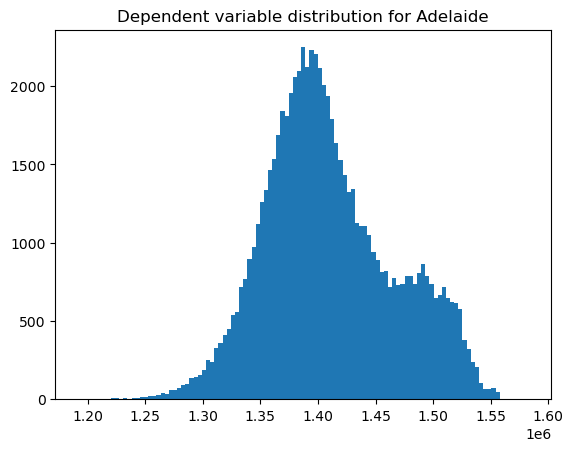

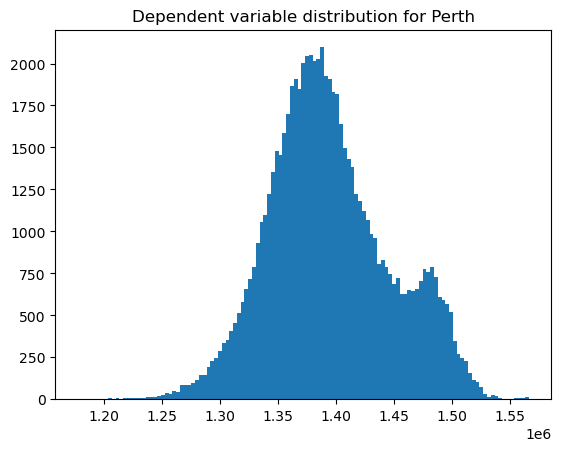

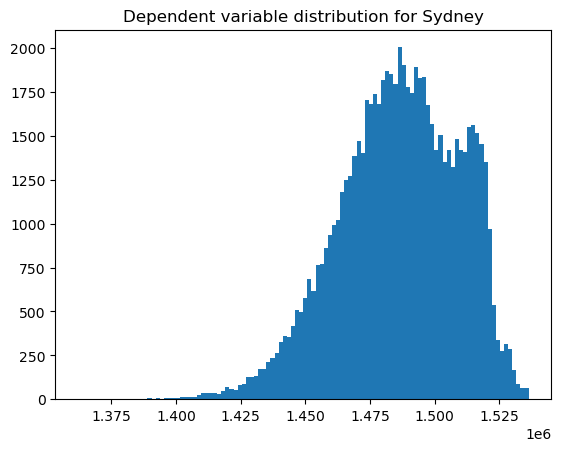

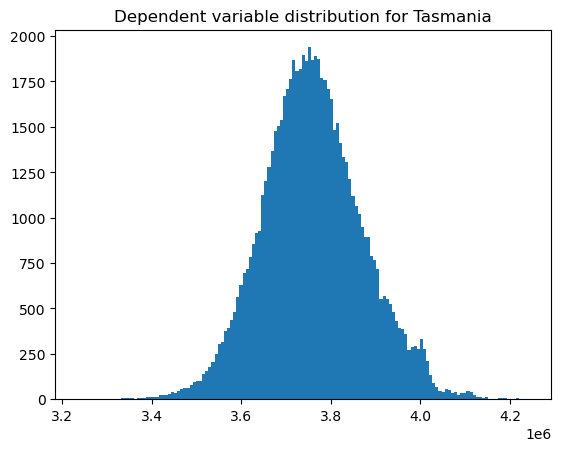

In [7]:
frames_dict = {"Adelaide": adelaide_df, "Perth": perth_df, "Sydney": sydney_df, "Tasmania": tasmania_df}
for key, frame in frames_dict.items():
    dep_var = frame['Powerall']
    plt.hist(frame['Powerall'], bins = 'auto')
    plt.title(f'Dependent variable distribution for {key}')
    plt.show()

In [8]:
class PipelineWrapper:
    def __init__(self, df: pd.DataFrame, labels, size, val_size, random):
        self.df = df
        self.labels = labels
        self.X = None
        self.y = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        self.process()
        self.split_sets(size, val_size, random)
    
    def process(self):
        self.X = self.df.drop('Powerall', axis=1)
        self.X = self.X.drop([i for i in self.labels], axis= 1)
        self.y = self.df['Powerall']
    
    def split_sets(self, size, val_size, random):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=size, random_state=random
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=val_size, random_state=random)
    
    def standard_scale(self):
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)
        self.X_test = scaler.transform(self.X_test)
    
    def plot_predicted_vs_actual(self, y_test, y_predict, name, r2, rmse, mape, show_plot=False):
        """Generates a scatter plot of predicted vs. actual values."""
        y_test_vals = y_test.values if hasattr(y_test, 'values') else y_test
        y_predict_vals = y_predict.flatten() if hasattr(y_predict, 'flatten') else y_predict

        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_vals, y_predict_vals, alpha=0.5, label='Predicted vs Actual')

        min_val = min(y_test_vals.min(), y_predict_vals.min())
        max_val = max(y_test_vals.max(), y_predict_vals.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit (y=x)')

        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Predicted vs Actual for {name}")
        plt.legend()
        plt.grid(True)

        textstr = f"R2: {r2:.4f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%"
        plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        if show_plot:
            plt.show()

        plots_dir = 'plots/predicted_vs_actual'
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)

        filename = name.replace(' ', '_') + '.png'
        filepath = os.path.join(plots_dir, filename)
        plt.savefig(filepath)
        plt.close()

    def plot_residuals(self, y_test, y_predict, name, r2, rmse, mape, show_plot=False):
        """Generates a scatter plot of residuals vs. predicted values."""
        y_test_vals = y_test.values if hasattr(y_test, 'values') else y_test
        y_predict_vals = y_predict.flatten() if hasattr(y_predict, 'flatten') else y_predict
        residuals = y_test_vals - y_predict_vals

        plt.figure(figsize=(8, 6))
        plt.scatter(y_predict_vals, residuals, alpha=0.5)
        plt.axhline(y=0, color='k', linestyle='--', lw=2)

        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals (Actual - Predicted)")
        plt.title(f"Residuals vs Predicted Values for {name}")
        plt.grid(True)

        textstr = f"R2: {r2:.4f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%"
        plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        if show_plot:
            plt.show()

        plots_dir = 'plots/residuals'
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)

        filename = name.replace(' ', '_') + '_residuals.png'
        filepath = os.path.join(plots_dir, filename)
        plt.savefig(filepath)
        plt.close()

    def plot_residuals_distribution(self, y_test, y_predict, name, r2, rmse, mape, show_plot=False):
        """Generates a histogram of the residuals to show their distribution."""
        y_test_vals = y_test.values if hasattr(y_test, 'values') else y_test
        y_predict_vals = y_predict.flatten() if hasattr(y_predict, 'flatten') else y_predict
        residuals = y_test_vals - y_predict_vals

        plt.figure(figsize=(8, 6))
        plt.hist(residuals, bins=50, density=True, alpha=0.6, color='g', label='Residuals Histogram')

        mu, std = stats.norm.fit(residuals)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')
        plt.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Residuals')

        plt.xlabel("Residuals")
        plt.ylabel("Density")
        plt.title(f"Residuals Distribution for {name}")
        plt.legend()
        plt.grid(True)

        textstr = f"R2: {r2:.4f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%"
        plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        if show_plot:
            plt.show()

        plots_dir = 'plots/residuals_distribution'
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)

        filename = name.replace(' ', '_') + '_residuals_dist.png'
        filepath = os.path.join(plots_dir, filename)
        plt.savefig(filepath)
        plt.close()

    def make_plots(self, y_test, y_predict, name, r2, rmse, mape):
        """Generate all three plots."""
        self.plot_predicted_vs_actual(y_test, y_predict, name, r2, rmse, mape)
        self.plot_residuals(y_test, y_predict, name, r2, rmse, mape)
        self.plot_residuals_distribution(y_test, y_predict, name, r2, rmse, mape)

    def train_evaluate_linear_regression(self):
        # Train model
        model_lr = LinearRegression()
        model_lr.fit(self.X_train, self.y_train)

        # Predict
        y_pred = model_lr.predict(self.X_test)

        # Evaluate
        r2 = r2_score(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = root_mean_squared_error(self.y_test, y_pred)

        metrics = {"R2": r2, "MAPE": mape, "RMSE": rmse}

        print("R2 Score:", r2)
        print("Mean Absolute Percentage Error:", mape)
        print("Root Mean Squared Error:", rmse)

        return model_lr, metrics
    
    def train_evaluate_polynomial_regression(self, degree=2):
        """Train polynomial regression model."""
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly_features.fit_transform(self.X_train)
        X_test_poly = poly_features.transform(self.X_test)

        model = LinearRegression()
        model.fit(X_train_poly, self.y_train)
        y_pred = model.predict(X_test_poly)

        r2 = r2_score(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))

        metrics = {"R2": r2, "MAPE": mape, "RMSE": rmse}

        print(f"Polynomial Regression (Degree {degree})")
        print("R2 Score:", r2)
        print("Mean Absolute Percentage Error:", mape)
        print("Root Mean Squared Error:", rmse)

        return model, metrics
    
    def train_evaluate_lightgbm(self, params=None):
        if params is None:
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': 0.1,
                'num_leaves': 31,
                'verbose': -1
            }

        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        val_data = lgb.Dataset(self.X_val, label=self.y_val, reference=train_data)

        model_lgb = lgb.train(params, train_data, num_boost_round=100, valid_sets=[val_data], callbacks=[lgb.early_stopping(10)])

        y_pred = model_lgb.predict(self.X_test, num_iteration=model_lgb.best_iteration)

        r2 = r2_score(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = root_mean_squared_error(self.y_test, y_pred)

        metrics = {"R2": r2, "MAPE": mape, "RMSE": rmse}

        print("R2 Score:", r2)
        print("Mean Absolute Percentage Error:", mape)
        print("Root Mean Squared Error:", rmse)

        return model_lgb, metrics
    
    def train_evaluate_xgboost(self):
        # Train model
        model_xgb = XGBRegressor(random_state=42, verbosity=0)
        model_xgb.fit(self.X_train, self.y_train)

        # Predict
        y_pred = model_xgb.predict(self.X_test)

        # Evaluate
        r2 = r2_score(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = root_mean_squared_error(self.y_test, y_pred)

        metrics = {"R2": r2, "MAPE": mape, "RMSE": rmse}

        print("R2 Score:", r2)
        print("Mean Absolute Percentage Error:", mape)
        print("Root Mean Squared Error:", rmse)

        return model_xgb, metrics
    
    def train_evaluate_catboost(self):
        """Train CatBoost regressor."""
        catboost_model = cb.CatBoostRegressor(
            iterations=4000,
            learning_rate=0.05,
            depth=7,
            l2_leaf_reg=3,
            random_seed=42,
            verbose=False,
            early_stopping_rounds=100
        )

        catboost_model.fit(
            self.X_train,
            self.y_train,
            eval_set=(self.X_val, self.y_val),
            verbose=False
        )

        y_pred = catboost_model.predict(self.X_test)

        r2 = r2_score(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))

        metrics = {"R2": r2, "MAPE": mape, "RMSE": rmse}

        print("CatBoost Regressor")
        print("R2 Score:", r2)
        print("Mean Absolute Percentage Error:", mape)
        print("Root Mean Squared Error:", rmse)

        return catboost_model, metrics



    def train_evaluate_optuna_xgboost(self, n_trials=50):
        """Train XGBoost with Optuna hyperparameter tuning."""
        def objective(trial):
            params = {
                "objective": "reg:squarederror",
                "eval_metric": "rmse",
                "n_estimators": 2000,
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
                "random_state": 42,
                "n_jobs": -1
            }

            model = xgb.XGBRegressor(**params, early_stopping_rounds=50)
            model.fit(self.X_train, self.y_train, eval_set=[(self.X_val, self.y_val)], verbose=False)
            trial.set_user_attr("best_iteration", model.best_iteration)

            y_pred = model.predict(self.X_val)
            rmse = np.sqrt(mean_squared_error(self.y_val, y_pred))
            return rmse

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

        print(f"Best RMSE: {study.best_value:.3f}")
        print("Best hyperparameters:", study.best_params)

        best_params = study.best_params
        best_iteration = study.best_trial.user_attrs["best_iteration"]

        X_train_full = pd.concat([pd.DataFrame(self.X_train), pd.DataFrame(self.X_val)]) if isinstance(self.X_train, np.ndarray) else pd.concat([self.X_train, self.X_val])
        y_train_full = pd.concat([pd.Series(self.y_train), pd.Series(self.y_val)]) if isinstance(self.y_train, np.ndarray) else pd.concat([self.y_train, self.y_val])

        final_model = xgb.XGBRegressor(**best_params, n_estimators=best_iteration, random_state=42, n_jobs=-1)
        final_model.fit(X_train_full, y_train_full)

        y_pred = final_model.predict(self.X_test)

        r2 = r2_score(self.y_test, y_pred)
        mape = mean_absolute_percentage_error(self.y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))

        metrics = {"R2": r2, "MAPE": mape, "RMSE": rmse}

        print("XGBoost with Optuna Tuning")
        print("R2 Score:", r2)
        print("Mean Absolute Percentage Error:", mape)
        print("Root Mean Squared Error:", rmse)

        return final_model, metrics

In [9]:
results = pd.DataFrame(columns=["City", "Model", "R2", "MAPE", "RMSE"])

In [10]:
cities = [adelaide_df, perth_df, sydney_df, tasmania_df]
city_labels = ["Adelaide", "Perth", "Sydney", "Tasmania"]

# Linear Regression
for idx, city in enumerate(cities):
    result = PipelineWrapper(city, labels = labelsP, size=0.20, val_size=0.25, random=42)
    print(50* "=")
    print(city_labels[idx])
    result.standard_scale()
    model, metrics = result.train_evaluate_linear_regression()

    y_pred = model.predict(result.X_test)
    result.make_plots(result.y_test, y_pred, f"{city_labels[idx]} - Linear Regression", metrics["R2"], metrics["RMSE"], metrics["MAPE"])
    
    results = pd.concat([results, pd.DataFrame([{
        "City": city_labels[idx],
        "Model": "Linear Regression",
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"],
        "RMSE": metrics["RMSE"]
    }])], ignore_index=True)

# LightGBM
for idx, city in enumerate(cities):
    result = PipelineWrapper(city, labels = labelsP, size=0.20, val_size=0.25, random=42)
    print(50* "=")
    print(city_labels[idx])
    result.standard_scale()
    model, metrics = result.train_evaluate_lightgbm()
    
    y_pred = model.predict(result.X_test, num_iteration=model.best_iteration)
    result.make_plots(result.y_test, y_pred, f"{city_labels[idx]} - LightGBM", metrics["R2"], metrics["RMSE"], metrics["MAPE"])
    
    results = pd.concat([results, pd.DataFrame([{
        "City": city_labels[idx],
        "Model": "LightGBM",
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"],
        "RMSE": metrics["RMSE"]
    }])], ignore_index=True)

# XGBoost
for idx, city in enumerate(cities):
    result = PipelineWrapper(city, labels = labelsP, size=0.20, val_size=0.25, random=42)
    print(50* "=")
    print(city_labels[idx])
    result.standard_scale()
    model, metrics = result.train_evaluate_xgboost()
    
    y_pred = model.predict(result.X_test)
    result.make_plots(result.y_test, y_pred, f"{city_labels[idx]} - XGBoost", metrics["R2"], metrics["RMSE"], metrics["MAPE"])
    
    results = pd.concat([results, pd.DataFrame([{
        "City": city_labels[idx],
        "Model": "XGBoost",
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"],
        "RMSE": metrics["RMSE"]
    }])], ignore_index=True)

Adelaide
R2 Score: 0.1767790407365366
Mean Absolute Percentage Error: 0.028901099697724572
Root Mean Squared Error: 50831.681031413835
Perth
R2 Score: 0.1338946322254143
Mean Absolute Percentage Error: 0.02739239563875179
Root Mean Squared Error: 48277.50850999139
Sydney
R2 Score: 0.12303651618490374
Mean Absolute Percentage Error: 0.011699363897719726
Root Mean Squared Error: 21609.678909248738
Tasmania
R2 Score: 0.14621792564937108
Mean Absolute Percentage Error: 0.021507678629396558
Root Mean Squared Error: 103742.31830522254
Adelaide
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 21229.3
R2 Score: 0.8583400440527703
Mean Absolute Percentage Error: 0.01141400641108193
Root Mean Squared Error: 21086.272466917184
Perth
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 21041.7
R2 Score: 0.8333408525682298
Mean Absolute Perc

In [11]:
results.head(100)

,City,Model,R2,MAPE,RMSE
0,Adelaide,Linear Regression,0.176779,0.028901,50831.681031
1,Perth,Linear Regression,0.133895,0.027392,48277.508510
2,Sydney,Linear Regression,0.123037,0.011699,21609.678909
3,Tasmania,Linear Regression,0.146218,0.021508,103742.318305
4,Adelaide,LightGBM,0.858340,0.011414,21086.272467
5,Perth,LightGBM,0.833341,0.011656,21177.469351
6,Sydney,LightGBM,0.847921,0.004456,8998.956910
7,Tasmania,LightGBM,0.754665,0.011458,55611.242804
8,Adelaide,XGBoost,0.873650,0.010720,19914.278791
9,Perth,XGBoost,0.839131,0.011418,20806.353422


In [12]:
# CatBoost
for idx, city in enumerate(cities):
    result = PipelineWrapper(city, labels = labelsP, size=0.20, val_size=0.25, random=42)
    print(50* "=")
    print(city_labels[idx])
    result.standard_scale()
    model, metrics = result.train_evaluate_catboost()
    
    y_pred = model.predict(result.X_test)
    result.make_plots(result.y_test, y_pred, f"{city_labels[idx]} - CatBoost", metrics["R2"], metrics["RMSE"], metrics["MAPE"])
    
    results = pd.concat([results, pd.DataFrame([{
        "City": city_labels[idx],
        "Model": "CatBoost",       
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"],
        "RMSE": metrics["RMSE"]
    }])], ignore_index=True)

# Polynomial Regression
for idx, city in enumerate(cities):
    result = PipelineWrapper(city, labels = labelsP, size=0.20, val_size=0.25, random=42)
    print(50* "=")
    print(city_labels[idx])
    result.standard_scale()
    model, metrics = result.train_evaluate_polynomial_regression(degree=2)
    
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_test_poly = poly_features.fit_transform(result.X_train)
    X_test_poly = poly_features.transform(result.X_test)
    y_pred = model.predict(X_test_poly)
    result.make_plots(result.y_test, y_pred, f"{city_labels[idx]} - Polynomial Regression Degree 2", metrics["R2"], metrics["RMSE"], metrics["MAPE"])
    
    results = pd.concat([results, pd.DataFrame([{
        "City": city_labels[idx],
        "Model": "Polynomial Regression",           
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"],
        "RMSE": metrics["RMSE"]
    }])], ignore_index=True)

# XGBoost with Optuna
for idx, city in enumerate(cities):
    result = PipelineWrapper(city, labels = labelsP, size=0.20, val_size=0.25, random=42)
    print(50* "=")
    print(city_labels[idx])
    # result.standard_scale()
    model, metrics = result.train_evaluate_optuna_xgboost(n_trials=20)
    
    y_pred = model.predict(result.X_test)
    result.make_plots(result.y_test, y_pred, f"{city_labels[idx]} - XGBoost with Optuna HPT - Optuna Tuning", metrics["R2"], metrics["RMSE"], metrics["MAPE"])
    
    results = pd.concat([results, pd.DataFrame([{
        "City": city_labels[idx],
        "Model": "XGBoost with Optuna",           
        "R2": metrics["R2"],
        "MAPE": metrics["MAPE"],
        "RMSE": metrics["RMSE"]
    }])], ignore_index=True)

Adelaide
CatBoost Regressor
R2 Score: 0.9103543916380837
Mean Absolute Percentage Error: 0.008905943078953633
Root Mean Squared Error: 16774.159650936053
Perth
CatBoost Regressor
R2 Score: 0.8883137925348769
Mean Absolute Percentage Error: 0.009360400896798907
Root Mean Squared Error: 17336.41345482265
Sydney
CatBoost Regressor
R2 Score: 0.9270787734525855
Mean Absolute Percentage Error: 0.002838266716871744
Root Mean Squared Error: 6231.384380601545
Tasmania
CatBoost Regressor
R2 Score: 0.8345977498292645
Mean Absolute Percentage Error: 0.009292368965129272
Root Mean Squared Error: 45661.8117704796
Adelaide
Polynomial Regression (Degree 2)
R2 Score: 0.845540524473587
Mean Absolute Percentage Error: 0.01238752953921986
Root Mean Squared Error: 22018.28762847992
Perth
Polynomial Regression (Degree 2)
R2 Score: 0.8168659738278294
Mean Absolute Percentage Error: 0.012532598702296786
Root Mean Squared Error: 22199.541544671465
Sydney
Polynomial Regression (Degree 2)
R2 Score: 0.82987198473

[I 2025-11-26 01:03:29,800] A new study created in memory with name: no-name-3e3be273-4b3f-4757-8e85-0cf160d391ca


Adelaide


[I 2025-11-26 01:03:37,670] Trial 0 finished with value: 19307.704896886396 and parameters: {'learning_rate': 0.010332423306733568, 'max_depth': 6, 'subsample': 0.9637040333360214, 'colsample_bytree': 0.9696590033972765, 'gamma': 0.08480352106453466, 'reg_alpha': 0.00014816072385543427, 'reg_lambda': 0.00011028486690455929}. Best is trial 0 with value: 19307.704896886396.
[I 2025-11-26 01:03:39,223] Trial 1 finished with value: 19176.28987779465 and parameters: {'learning_rate': 0.23299010318544436, 'max_depth': 5, 'subsample': 0.6928916912665939, 'colsample_bytree': 0.8455553917889859, 'gamma': 4.987189256967924e-06, 'reg_alpha': 4.5669453048178426e-05, 'reg_lambda': 0.005279688592733938}. Best is trial 1 with value: 19176.28987779465.
[I 2025-11-26 01:03:42,923] Trial 2 finished with value: 19880.487181277436 and parameters: {'learning_rate': 0.23762209598394804, 'max_depth': 7, 'subsample': 0.7061030646102276, 'colsample_bytree': 0.8922601265267556, 'gamma': 5.385249974256795e-05, '

Best RMSE: 17594.924
Best hyperparameters: {'learning_rate': 0.051570096832110175, 'max_depth': 8, 'subsample': 0.768822688244704, 'colsample_bytree': 0.6748086289809986, 'gamma': 0.001289656888971371, 'reg_alpha': 1.8783585171325971e-06, 'reg_lambda': 9.502634560568204}
XGBoost with Optuna Tuning
R2 Score: 0.9078382123866173
Mean Absolute Percentage Error: 0.008917878485928963
Root Mean Squared Error: 17007.939711804323


[I 2025-11-26 01:07:13,482] A new study created in memory with name: no-name-44b46b6f-78b4-4cd6-8de5-27541213c96f


Perth


[I 2025-11-26 01:07:30,210] Trial 0 finished with value: 18453.559315552167 and parameters: {'learning_rate': 0.013424327867938297, 'max_depth': 8, 'subsample': 0.8993823342323192, 'colsample_bytree': 0.9381365935367975, 'gamma': 1.611093585187071e-07, 'reg_alpha': 3.4207217513848605, 'reg_lambda': 0.10200529975017872}. Best is trial 0 with value: 18453.559315552167.
[I 2025-11-26 01:07:44,080] Trial 1 finished with value: 18385.74579394243 and parameters: {'learning_rate': 0.06781176158090645, 'max_depth': 8, 'subsample': 0.7967158626445372, 'colsample_bytree': 0.71258146976938, 'gamma': 0.12138412768126132, 'reg_alpha': 5.729906534637001e-08, 'reg_lambda': 1.1152319547421}. Best is trial 1 with value: 18385.74579394243.
[I 2025-11-26 01:07:50,564] Trial 2 finished with value: 18454.70334661259 and parameters: {'learning_rate': 0.017219660365802737, 'max_depth': 6, 'subsample': 0.9645629655779817, 'colsample_bytree': 0.6602755475287329, 'gamma': 9.893900114545712e-08, 'reg_alpha': 0.0

Best RMSE: 17634.538
Best hyperparameters: {'learning_rate': 0.027831091190872615, 'max_depth': 7, 'subsample': 0.7213149808892704, 'colsample_bytree': 0.8524118627421446, 'gamma': 3.2934616671112127e-06, 'reg_alpha': 0.24850005293791588, 'reg_lambda': 7.3635105761413895}
XGBoost with Optuna Tuning
R2 Score: 0.8882770148655479
Mean Absolute Percentage Error: 0.009370516824636002
Root Mean Squared Error: 17339.267613879183


[I 2025-11-26 01:11:00,310] A new study created in memory with name: no-name-c4ce5168-ad36-495a-9df4-aa6641a70fe3


Sydney


[I 2025-11-26 01:11:03,951] Trial 0 finished with value: 7479.665824670938 and parameters: {'learning_rate': 0.13915434733724238, 'max_depth': 3, 'subsample': 0.6278601678294748, 'colsample_bytree': 0.8445833960636573, 'gamma': 0.01461947732630441, 'reg_alpha': 0.0026071167190249178, 'reg_lambda': 0.00039496247798231384}. Best is trial 0 with value: 7479.665824670938.
[I 2025-11-26 01:11:08,062] Trial 1 finished with value: 6701.866237835455 and parameters: {'learning_rate': 0.24091986517618422, 'max_depth': 4, 'subsample': 0.824247476213345, 'colsample_bytree': 0.6058359223635501, 'gamma': 1.1250457218424831e-07, 'reg_alpha': 4.763765966517091e-08, 'reg_lambda': 1.5155328770990018e-05}. Best is trial 1 with value: 6701.866237835455.
[I 2025-11-26 01:11:18,160] Trial 2 finished with value: 6630.483789756928 and parameters: {'learning_rate': 0.026969165420068174, 'max_depth': 7, 'subsample': 0.6062147771605257, 'colsample_bytree': 0.9611889584588429, 'gamma': 1.928754160137786e-05, 'reg

Best RMSE: 6401.362
Best hyperparameters: {'learning_rate': 0.06626680030276069, 'max_depth': 6, 'subsample': 0.8344819662525464, 'colsample_bytree': 0.6745398910699771, 'gamma': 0.0002594647845226468, 'reg_alpha': 1.5875742177311426e-06, 'reg_lambda': 7.269248981276417e-07}
XGBoost with Optuna Tuning
R2 Score: 0.934679429021438
Mean Absolute Percentage Error: 0.0024889442759231826
Root Mean Squared Error: 5897.698202888414


[I 2025-11-26 01:14:04,594] A new study created in memory with name: no-name-970d7630-eb50-4106-9f12-c7fa45d49ecf


Tasmania


[I 2025-11-26 01:14:07,807] Trial 0 finished with value: 53808.42352024383 and parameters: {'learning_rate': 0.03345826912906192, 'max_depth': 3, 'subsample': 0.9393295402508836, 'colsample_bytree': 0.6911839618805447, 'gamma': 0.000189870317340747, 'reg_alpha': 3.817530088511773e-06, 'reg_lambda': 1.6504712474565603e-08}. Best is trial 0 with value: 53808.42352024383.
[I 2025-11-26 01:14:11,446] Trial 1 finished with value: 48397.24392115652 and parameters: {'learning_rate': 0.11859842555497149, 'max_depth': 3, 'subsample': 0.6028477618132457, 'colsample_bytree': 0.7297668251852887, 'gamma': 1.7453894029655895e-08, 'reg_alpha': 6.709732587920943, 'reg_lambda': 6.664417435182812e-07}. Best is trial 1 with value: 48397.24392115652.
[I 2025-11-26 01:14:35,288] Trial 2 finished with value: 48888.82616352167 and parameters: {'learning_rate': 0.02612373784078178, 'max_depth': 9, 'subsample': 0.612626018135486, 'colsample_bytree': 0.8346647803786036, 'gamma': 2.0286904513754486e-06, 'reg_alp

Best RMSE: 46367.785
Best hyperparameters: {'learning_rate': 0.06619380589460507, 'max_depth': 5, 'subsample': 0.7512299225448132, 'colsample_bytree': 0.9136990100789937, 'gamma': 0.04375840281921105, 'reg_alpha': 6.326509825054745e-05, 'reg_lambda': 0.182825395964484}
XGBoost with Optuna Tuning
R2 Score: 0.8294423651373205
Mean Absolute Percentage Error: 0.009466383610057773
Root Mean Squared Error: 46367.962780951166


In [13]:
results.head(100)

,City,Model,R2,MAPE,RMSE
0,Adelaide,Linear Regression,0.176779,0.028901,50831.681031
1,Perth,Linear Regression,0.133895,0.027392,48277.508510
2,Sydney,Linear Regression,0.123037,0.011699,21609.678909
3,Tasmania,Linear Regression,0.146218,0.021508,103742.318305
4,Adelaide,LightGBM,0.858340,0.011414,21086.272467
5,Perth,LightGBM,0.833341,0.011656,21177.469351
6,Sydney,LightGBM,0.847921,0.004456,8998.956910
7,Tasmania,LightGBM,0.754665,0.011458,55611.242804
8,Adelaide,XGBoost,0.873650,0.010720,19914.278791
9,Perth,XGBoost,0.839131,0.011418,20806.353422


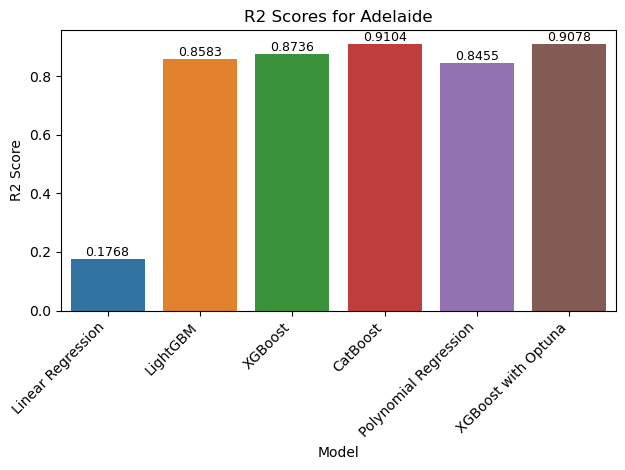

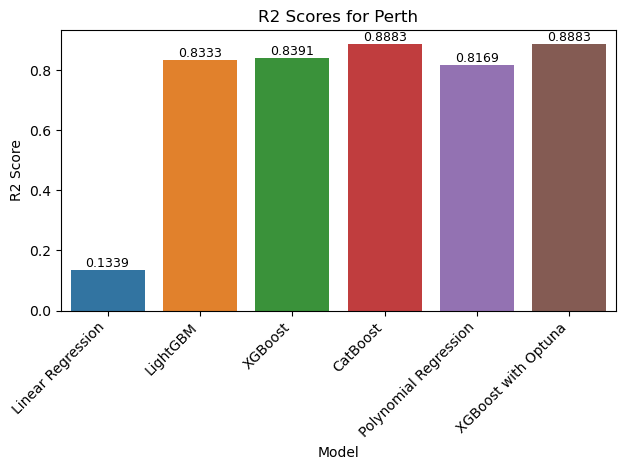

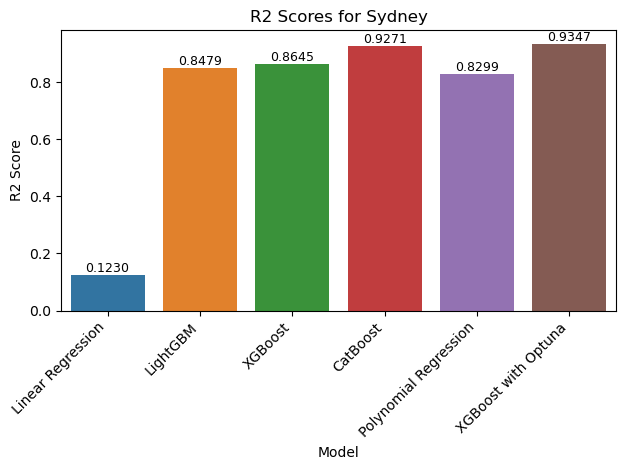

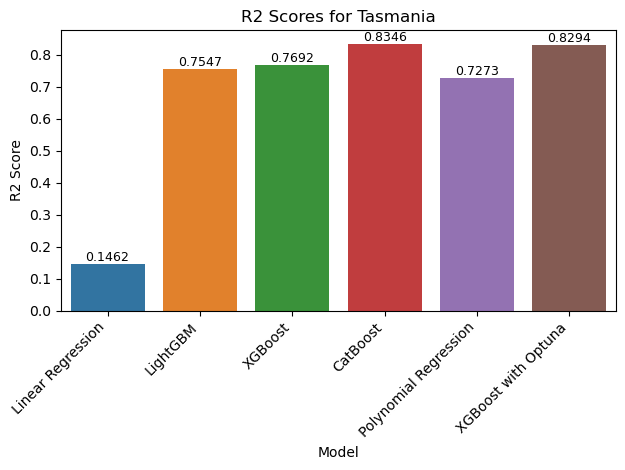

In [14]:
cities = ["Adelaide", "Perth", "Sydney", "Tasmania"]
for city in cities:
    city_results = results[results['City'] == city]
    ax = sns.barplot(data=city_results, x="Model", y="R2", hue="Model", legend=False)
    plt.title(f'R2 Scores for {city}')
    plt.xlabel('Model')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=45, ha='right')

    # Add values on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height,
                f'{height:.4f}',
                ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

Adelaide: CatBoost (RMSE: 16774.16)
Perth: CatBoost (RMSE: 17336.41)
Sydney: XGBoost with Optuna (RMSE: 5897.70)
Tasmania: CatBoost (RMSE: 45661.81)


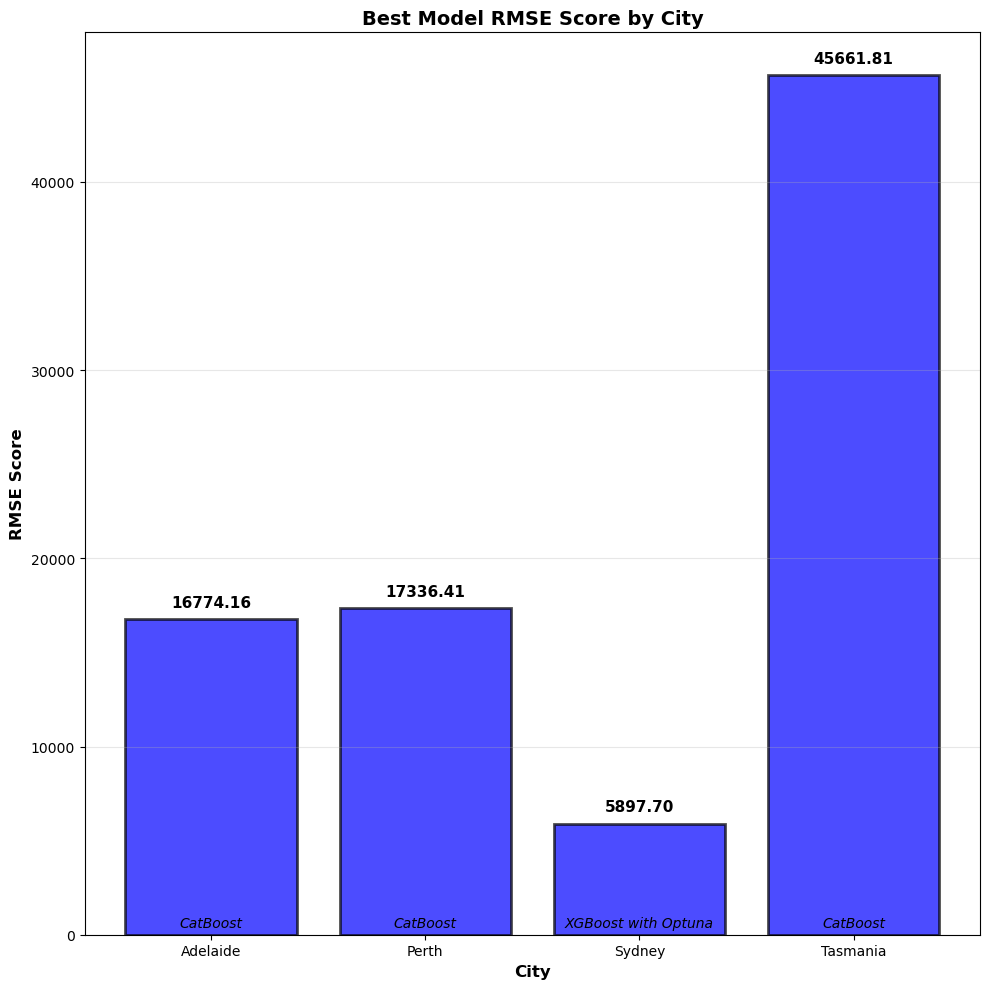

In [15]:
cities = ["Adelaide", "Perth", "Sydney", "Tasmania"]
best_rmse_scores = []
best_models_list = []

for city in cities:
    city_results = results[results['City'] == city]
    best_idx = city_results['RMSE'].idxmin()
    best_model = results.loc[best_idx]
    best_rmse_scores.append(best_model['RMSE'])
    best_models_list.append(best_model['Model'])
    print(f"{city}: {best_model['Model']} (RMSE: {best_model['RMSE']:.2f})")

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 10))
bars = ax.bar(cities, best_rmse_scores, color='blue', alpha=0.7, edgecolor='black', linewidth=2)

ax.set_xlabel('City', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE Score', fontsize=12, fontweight='bold')
ax.set_title('Best Model RMSE Score by City', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on top of bars and model names
y_min = ax.get_ylim()[0]
for i, (bar, val, model) in enumerate(zip(bars, best_rmse_scores, best_models_list)):
    ax.text(bar.get_x() + bar.get_width()/2., val + 500, f'{val:.2f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax.text(bar.get_x() + bar.get_width()/2., y_min + 1000, model,
            ha='center', va='top', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

Adelaide: CatBoost (R2: 0.91)
Perth: CatBoost (R2: 0.89)
Sydney: XGBoost with Optuna (R2: 0.93)
Tasmania: CatBoost (R2: 0.83)


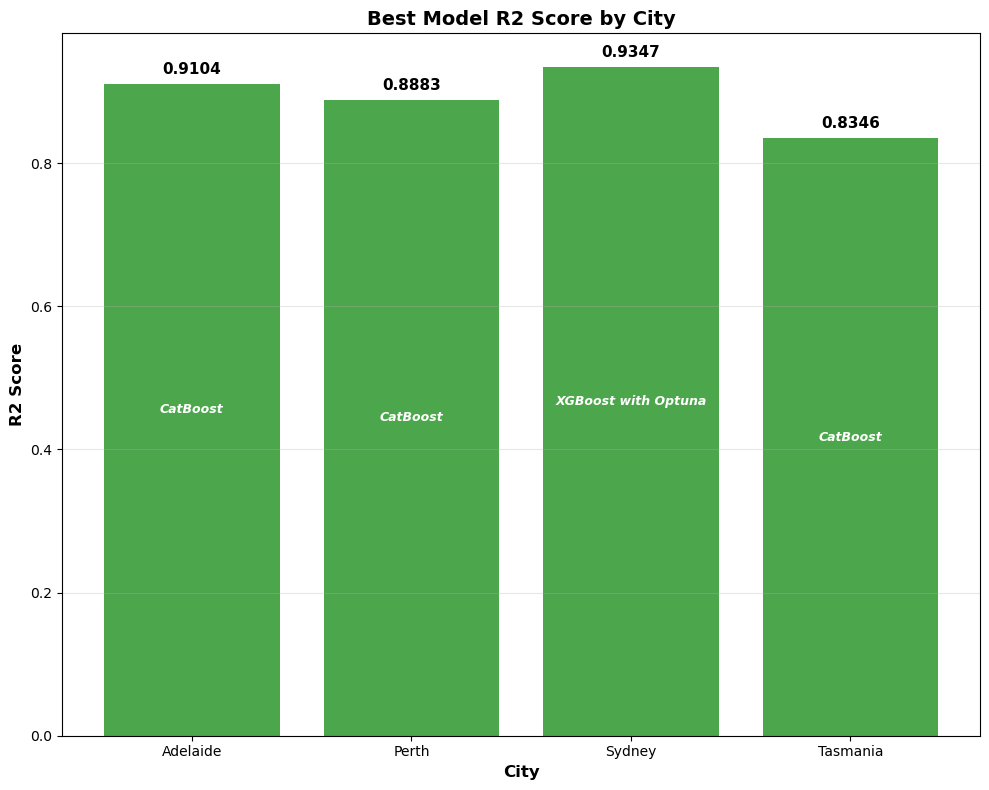

In [19]:
cities = ["Adelaide", "Perth", "Sydney", "Tasmania"]
best_rmse_scores = []
best_models_list = []

for city in cities:
    city_results = results[results['City'] == city]
    best_idx = city_results['R2'].idxmax()
    best_model = results.loc[best_idx]
    best_rmse_scores.append(best_model['R2'])
    best_models_list.append(best_model['Model'])
    print(f"{city}: {best_model['Model']} (R2: {best_model['R2']:.2f})")

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.bar(cities, best_rmse_scores, color='green', alpha=0.7, linewidth=2)

ax.set_xlabel('City', fontsize=12, fontweight='bold')
ax.set_ylabel('R2 Score', fontsize=12, fontweight='bold')
ax.set_title('Best Model R2 Score by City', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on top of bars and model names
for i, (bar, val, model) in enumerate(zip(bars, best_rmse_scores, best_models_list)):
    # Add R2 value on top
    ax.text(bar.get_x() + bar.get_width()/2., val + 0.01, f'{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    # Add model name inside the bar
    ax.text(bar.get_x() + bar.get_width()/2., val/2, model,
            ha='center', va='center', fontsize=9, style='italic', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

Adelaide: CatBoost (RMSE: 16774.16)
Perth: CatBoost (RMSE: 17336.41)
Sydney: XGBoost with Optuna (RMSE: 5897.70)
Tasmania: CatBoost (RMSE: 45661.81)


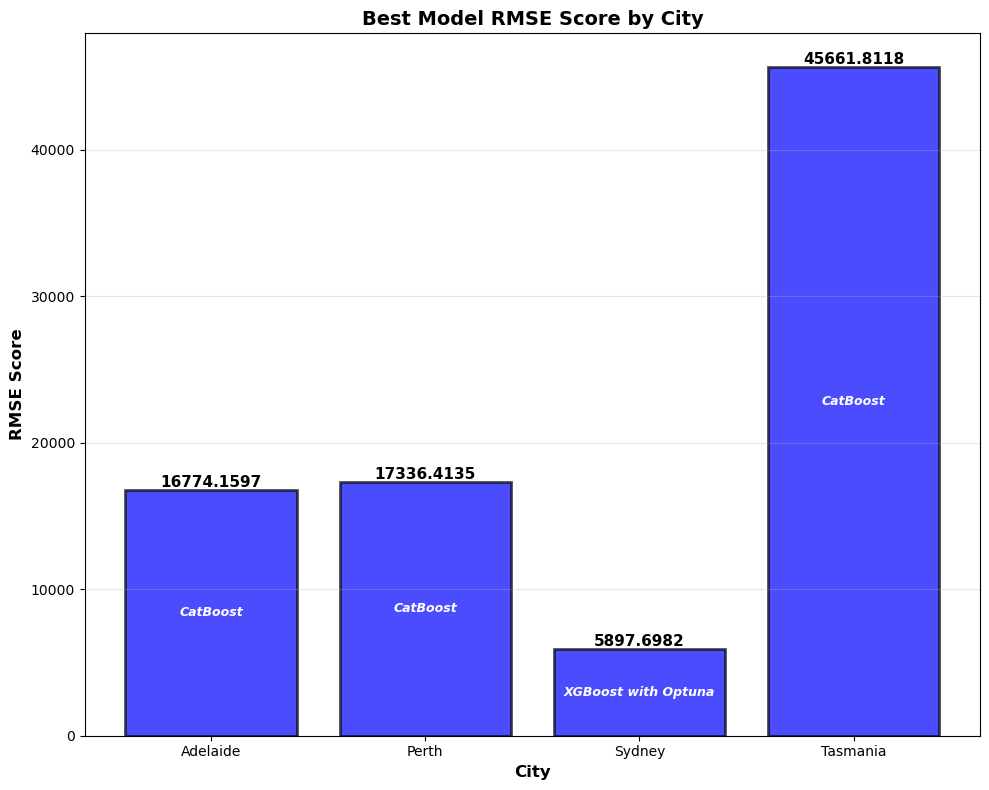

In [17]:
cities = ["Adelaide", "Perth", "Sydney", "Tasmania"]
best_rmse_scores = []
best_models_list = []

for city in cities:
    city_results = results[results['City'] == city]
    best_idx = city_results['RMSE'].idxmin()
    best_model = results.loc[best_idx]
    best_rmse_scores.append(best_model['RMSE'])
    best_models_list.append(best_model['Model'])
    print(f"{city}: {best_model['Model']} (RMSE: {best_model['RMSE']:.2f})")

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.bar(cities, best_rmse_scores, color='blue', alpha=0.7, edgecolor='black', linewidth=2)

ax.set_xlabel('City', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE Score', fontsize=12, fontweight='bold')
ax.set_title('Best Model RMSE Score by City', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on top of bars and model names
for i, (bar, val, model) in enumerate(zip(bars, best_rmse_scores, best_models_list)):
    # Add R2 value on top
    ax.text(bar.get_x() + bar.get_width()/2., val + 0.01, f'{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    # Add model name inside the bar
    ax.text(bar.get_x() + bar.get_width()/2., val/2, model,
            ha='center', va='center', fontsize=9, style='italic', color='white', fontweight='bold')

plt.tight_layout()
plt.show()